# Creation of COVID-19 stringency indices on the federal state level of Germany

The aim of this notebook is to give researches using the coronanet data the possibility to construct stringency indices on the federal state level of Germany. With the given functions researches can constrcut ordinal (closed-2; open with condition-1; open without conditions-0) & binary stringency variables (regulation in place-1, not in place-0). \
As described in 2.2 (especially Figure 2), occurring data gaps caused by various factors (e.g. missing end dates OR missing policies) need to be closed either manually or automatically. This notebook provides a 'manual_change' function to add additional data to close occuring data gaps. In the original code I have used manual filling of the data gaps construct the subindices used in my thesis paper. In this notebook, we use a pandas 'forward fill' method to close the data gaps. \
I highly recommend to do the additional research needed to manually close the occuring data gaps or inconsitencies. \
I didn't include the manual data collections from my thesis because I created the 'manual change' after the submission of my thesis. Also the stringency subindices C5 to C7 are not included in the notebook. In case anyone wants to include the manual data gatherings I have made in my thesis OR needs information about the subindices C5 to C7, please contact me.\
Contact me on GitHub or LinkedIn if you have any further questions or recommendations. 

Best\
Tim

In [1]:
# Import essential libraries

import pandas as pd
import numpy as np

from datetime import date

import seaborn as sns
import matplotlib.pyplot as plt

### Data Importing

In [2]:
# Import data from 'coronanet.org' (extended variables version)
url_conet_allvars = "https://raw.githubusercontent.com/CoronaNetDataScience/corona_tscs/master/data/CoronaNet/data_country/coronanet_release_allvars/coronanet_release_allvars_Germany.csv"

# df with national, federal state & municipal data
df_covid_all = pd.read_csv(
                url_conet_allvars, 
                index_col = None, 
                usecols = ['record_id', 'policy_id', 'entry_type', 'update_type', 
                      'update_level', 'description', 'date_announced', 'date_start', 
                      'date_end', 'init_country_level', 'province', 'city', 'type', 
                      'type_sub_cat', 'institution_status'],
               )

### Data Cleansing & Transformation

global

In [3]:
# transform date columns to datetimefromat
df_covid_all['date_announced'] = pd.to_datetime(df_covid_all['date_announced'])
df_covid_all['date_start'] = pd.to_datetime(df_covid_all['date_start'])
df_covid_all['date_end'] = pd.to_datetime(df_covid_all['date_end'])

# print variable types to check Dtypes
df_covid_all.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5427 entries, 0 to 5426
Data columns (total 15 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   record_id           5427 non-null   object        
 1   policy_id           5427 non-null   object        
 2   entry_type          5427 non-null   object        
 3   update_type         2275 non-null   object        
 4   update_level        1399 non-null   object        
 5   description         5427 non-null   object        
 6   date_announced      5427 non-null   datetime64[ns]
 7   date_start          5427 non-null   datetime64[ns]
 8   date_end            4585 non-null   datetime64[ns]
 9   init_country_level  5426 non-null   object        
 10  province            5220 non-null   object        
 11  city                96 non-null     object        
 12  type                5427 non-null   object        
 13  type_sub_cat        5023 non-null   object      

In [4]:
# trasform 'Yes, it is at the province/state level.' & 'Yes, it is at the provincial level' to 'Province' on 'init_country_level'
df_covid_all.loc[df_covid_all.init_country_level == 'Yes, it is at the province/state level.', 'init_country_level'] = 'Provincial'
df_covid_all.loc[df_covid_all.init_country_level == 'Yes, it is at the provincial level', 'init_country_level'] = 'Provincial'

# check for new wronlgy categorized entries (expected: 'Municipal', 'Provincial', 'National')
df_covid_all['init_country_level'].unique()

array(['Municipal', 'Provincial', 'National', nan], dtype=object)

----------------------------------

### Functions for Data Cleansing & Transformation


In [5]:
def subset_subind(subind, category):
    """
    subset df_covid_all for stringency subindices.
    subsets for init_country_level = 'Provincial' & 'National'.
    subsets for subindex category (e.g. 'Closure and Regulation of Schools').
    stores results in dataframe dictionary (subset_df_dict)
    
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 
    
    category : str
        category to subset on (e.g. 'Closure and Regulation of Schools')

    Returns
    ----------
    df_subind
        returns pandas DataFrame
    """
    
    subset_df_dict[subind] = df_covid_all[ (df_covid_all['init_country_level'].isin(['Provincial', 'National'])) 
                                            & (df_covid_all["type"] == category) ]

   
    return subset_df_dict[subind]

In [6]:
def institution_status_dummies(subind):
    """
    creates 'closed', 'open with condition', 'open without conditions' dummies
    
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 

    """
    pd.options.mode.chained_assignment = None
    
    subset_df_dict[subind]['closed_dum'] = subset_df_dict[subind]['institution_status'].str.contains(r'closed/locked down')
    subset_df_dict[subind]['condition_dum'] = subset_df_dict[subind]['institution_status'].str.contains(r'open with conditions')
    subset_df_dict[subind]['open_dum'] = subset_df_dict[subind]['institution_status'].str.contains(r'open with no conditions')

In [7]:
def subcat_create_listing(subind):
    """
    creates subcategories list of subindex
    
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 
        

    Return
    -----------
    subind_list : list
        list of subcategories of subindex
    
    """
    
    list_dict_subcat[subind] = (list(set(subset_df_dict[subind]['type_sub_cat'].values)))
    
    # drop 'nan'
    list_dict_subcat[subind] = [x for x in list_dict_subcat[subind] if str(x) != 'nan']
    
    return list_dict_subcat[subind]

In [8]:
def create_df_subind_subcat_feds(subind, federal_list, subcat_list):
    """
    creates empty stringency dataframes for subindices in a given date range.
    creates dataframe for each subcat (e.g. 'Primary Schools') for each federal state in given the subindex (e.g. C1)
    
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 
    
    federal_list : list
        list of federal states
        
    subcat_list : list
        list of subcategories

    """
    subind_data_dict[subind] = {}
    
    for fed in federal_list:
        for subcat in subcat_list:
            subind_data_dict[subind][str(fed) + '_' + str(subcat)] = pd.DataFrame()
            subind_data_dict[subind][str(fed) + '_' + str(subcat)][['stringency']] = np.nan
            subind_data_dict[subind][str(fed) + '_' + str(subcat)][['date']] = pd.date_range('01-01-2020', '01-01-2022')
            subind_data_dict[subind][str(fed) + '_' + str(subcat)][['manual_change']] = False
            subind_data_dict[subind][str(fed) + '_' + str(subcat)][['manual_id']] = ' '
            subind_data_dict[subind][str(fed) + '_' + str(subcat)][['manual_description']] = ' '
            subind_data_dict[subind][str(fed) + '_' + str(subcat)][['manual_source']] = ' '

In [9]:
def create_stringency_index_ordinal_provincial(subind, entry_type):
    """
    creates stringency index of subindex for each subcategory and each federal state (e.g. 'c1 - primary_schools - berlin')
    based on provincial policies.
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 
    
    entry_type : str
        category of entry type (e.g. 'new_entry', 'update')
        
    """
    
    #for each fed & each c1_subcat
    for fed in federal_list:
    
        for subcat in list_dict_subcat[subind]:
        
        #iterate over each row of subindex subset
            for index, row in subset_df_dict[subind].iterrows():
                
                if (row['province'] == fed) & (row['entry_type'] == entry_type) & (row['type_sub_cat'] == subcat):
                    
                    #create list of indices of of the target dataframe (subind[subcat_fed]) that are inbetween the date condition (start to end date of policy)
                    list_ind = subind_data_dict[subind][str(fed) + '_' + str(subcat)].index[(subind_data_dict[subind][str(fed) + '_' + str(subcat)]['date'] <= row['date_end']) 
                                                                                        & (subind_data_dict[subind][str(fed) + '_' + str(subcat)]['date'] >= row['date_start'])].tolist()
                
                    #fill cells in fed_subact based on institutional status dummy
                    if row['closed_dum']:
                        for ind in list_ind:
                            subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[ind, 'stringency'] = 0
                    
                    elif row['condition_dum']:
                        for ind in list_ind:
                            subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[ind, 'stringency'] = 1
                        
                    elif row['closed_dum']:
                        for ind in list_ind:
                            subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[ind, 'stringency'] = 2
                    
                    else:
                        pass
                else:
                    pass

In [10]:
def create_stringency_index_ordinal_national(subind, entry_type):
    """
    creates stringency index of subindex for each subcategory and each federal state (e.g. 'c1 - primary_schools - berlin').
    based on national policies.
    
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 
    
    entry_type : str
        category of entry type (e.g. 'new_entry', 'update')
        
    """
    
    #for each fed & each c1_subcat
    for fed in federal_list:
    
        for subcat in list_dict_subcat[subind]:
        
        #iterate over each row of subindex subset
            for index, row in subset_df_dict[subind].iterrows():
                
                if (row['init_country_level'] == 'National') & (row['entry_type'] == entry_type) & (row['type_sub_cat'] == subcat):
                    
                    #create list of indices of of the target dataframe (subind[subcat_fed]) that are inbetween the date condition (start to end date of policy)
                    list_ind = subind_data_dict[subind][str(fed) + '_' + str(subcat)].index[(subind_data_dict[subind][str(fed) + '_' + str(subcat)]['date'] <= row['date_end']) 
                                                                                        & (subind_data_dict[subind][str(fed) + '_' + str(subcat)]['date'] >= row['date_start'])].tolist()
                
                    #fill cells in fed_subact based on institutional status dummy
                    if row['closed_dum']:
                        for ind in list_ind:
                            subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[ind, 'stringency'] = 0
                    
                    elif row['condition_dum']:
                        for ind in list_ind:
                            subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[ind, 'stringency'] = 1
                        
                    elif row['closed_dum']:
                        for ind in list_ind:
                            subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[ind, 'stringency'] = 2
                    
                    else:
                        pass
                else:
                    pass

In [11]:
def create_stringency_index_dummy_provincial(subind, entry_type):
    """
    creates stringency index of subindex for each subcategory and each federal state (e.g. 'c1 - primary_schools - berlin')
    based on provincial policies.
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 
    
    entry_type : str
        category of entry type (e.g. 'new_entry', 'update')
        
    """
    
    #for each fed & each c1_subcat
    for fed in federal_list:
    
        for subcat in list_dict_subcat[subind]:
        
        #iterate over each row of subindex subset
            for index, row in subset_df_dict[subind].iterrows():
                
                if (row['province'] == fed) & (row['entry_type'] == entry_type):
                    
                    #create list of indices of of the target dataframe (subind[subcat_fed]) that are inbetween the date condition (start to end date of policy)
                    list_ind = subind_data_dict[subind][str(fed) + '_' + str(subcat)].index[(subind_data_dict[subind][str(fed) + '_' + str(subcat)]['date'] <= row['date_end']) 
                                                                                        & (subind_data_dict[subind][str(fed) + '_' + str(subcat)]['date'] >= row['date_start'])].tolist()
                
                    #fill cells in fed_subact based if measurements in place
                    
                    for ind in list_ind:
                        subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[ind, 'stringency'] = 1
                    
                    else:
                        pass
                else:
                    pass

In [12]:
def create_stringency_index_dummy_national(subind, entry_type):
    """
    creates stringency index of subindex for each subcategory and each federal state (e.g. 'c1 - primary_schools - berlin').
    based on national policies.
    
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 
    
    entry_type : str
        category of entry type (e.g. 'new_entry', 'update')
        
    """
    
    #for each fed & each c1_subcat
    for fed in federal_list:
    
        for subcat in list_dict_subcat[subind]:
        
        #iterate over each row of subindex subset
            for index, row in subset_df_dict[subind].iterrows():
                
                if (row['init_country_level'] == 'National') & (row['entry_type'] == entry_type):
                    
                     #create list of indices of of the target dataframe (subind[subcat_fed]) that are inbetween the date condition (start to end date of policy)
                    list_ind = subind_data_dict[subind][str(fed) + '_' + str(subcat)].index[(subind_data_dict[subind][str(fed) + '_' + str(subcat)]['date'] <= row['date_end']) 
                                                                                        & (subind_data_dict[subind][str(fed) + '_' + str(subcat)]['date'] >= row['date_start'])].tolist()
                
                    #fill cells in fed_subact based if measurements in place
                    
                    for ind in list_ind:
                        subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[ind, 'stringency'] = 1
                    
                    else:
                        pass
                else:
                    pass

In [13]:
def manual_change(subind, fed, subcat, start_date, end_date, status, idnr, source, description):
    """
    manually change stringency indices.
    
    
    Example   
    ----------------
    manual_change('c1', 'Berlin', 'Primary Schools (generally for children ages 10 and below)', 
                  date(2020, 1, 1), date(2021, 1, 1), 2, '1','https:website', 
                  'according to source primary schools are closed')
    
    Parameters
    -----------

    subind : str
        name of subindex (e.g. 'c1') 
    
    fed : str
        name of federal state (e.g. 'Berlin')
    
    subcat : str
        name of subcategory of subinde (e.g. Primary Schools (generally for children ages 10 and below))
    
    start_date : date
        start date of manual change
    
    end_date : date
        end date of manual change
        
    status : int 
        institution status (0 = open, 1 = open with condition, 2 = closed)
    
    idnr : str
        ID-number of the manual change
    
    source : str
        source of the manual change (e.g. 'record_id', 'link')
    
    description : str
        description of the manual change (e.g. 'record_id R12345 is an open end policy starting from 01.01.2020')

        
    """
    
    
    for index, row in subind_data_dict[subind][str(fed) + '_' + str(subcat)].iterrows():
       
        if (row['date'] >= start_date) & (row['date'] < end_date):
                subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[index, 'manual_change'] = True
                subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[index, 'stringency'] = status
                subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[index, 'manual_id'] = idnr
                subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[index, 'manual_source'] = source
                subind_data_dict[subind][str(fed) + '_' + str(subcat)].at[index, 'manual_description'] = description
                

In [14]:
def nan_stringency_filler(subind):
    """
    first, forward fill empty stringency data.
    second, remaining Nan set to zero.
   
    Parameters
    -----------

    subind : str
       name of subindex (e.g. 'c1')
       
    """

    for fed in federal_list:
    
        for subcat in list_dict_subcat[subind]:
            subind_data_dict[subind][str(fed) + '_' + str(subcat)].stringency.fillna(method='ffill', inplace=True)
            subind_data_dict[subind][str(fed) + '_' + str(subcat)].stringency.fillna(0, inplace=True)

In [15]:
def nan_stringency_filler_dummy(subind):
    """
    First, Nan set to zero.
   
    Parameters
    -----------

    subind : str
       name of subindex (e.g. 'c1')
       
    """

    for fed in federal_list:
    
        for subcat in list_dict_subcat[subind]:
            subind_data_dict[subind][str(fed) + '_' + str(subcat)].stringency.fillna(0, inplace=True)

In [16]:
def merging_subcat_fed_to_subindex_fed(subind):
    """
    merging subindex_fed_subcat dataframes to subindex_fed df
   
    Parameters
    -----------

    subind : str
       name of subindex (e.g. 'c1')
       
    """

    for fed in federal_list:
        
        subind_data_dict[subind][fed] = pd.DataFrame()
        subind_data_dict[subind][fed]['date'] = pd.date_range('01-01-2020', '01-01-2022')
    
        for subcat in list_dict_subcat[subind]:
            extracted_col = subind_data_dict[subind][str(fed) + '_' + str(subcat)]['stringency']
            subind_data_dict[subind][fed].insert(1, str(subcat), extracted_col)
            
        subind_data_dict[subind][fed][subind] = subind_data_dict[subind][fed].sum(axis=1, numeric_only=True)

In [17]:
def merging_subindex_fed_to_subind_df(subind):
    """
    merging subindex_fed df to subindex df
   
    Parameters
    -----------

    subind : str
       name of subindex (e.g. 'c1')
       
    """
   
    subind_data_dict[subind][subind] = pd.DataFrame()
    subind_data_dict[subind][subind]['date'] = pd.date_range('01-01-2020', '01-01-2022')
    
    for fed in federal_list:
        subind_data_dict[subind][subind][str(subind) + '_' + str(fed)] = subind_data_dict[subind][fed][subind]
        
    subind_data_dict[subind][subind]['Germany'] = subind_data_dict[subind][fed].mean(axis=1, numeric_only=True)
    
        
        

---------------------------

## Data Storage

In [18]:
# create a dict to store dataframe subset
# here you will later find the raw data subsets for each subindex

subset_df_dict = {} # e.g. subset_df_dict['c1']

In [19]:
# createa dict to store a lists of used subcategories
# here you will later find a list of all subcategories for the subindex (e.g. 'Primary Schools', 'Kindergarden' for 'C1-Schools')
# modify the list of used subcategories here to delete certain subcategories

list_dict_subcat = {} # e.g. list_dict_subcat['c1']


In [20]:
# create a df dict to store transformed dataframes regarding the subindices
# here you will alter find the stringency data for:
#
#     A: data of subcategories of the subindex for each federal state
#        e.g. subind_data_dict['c1']['Berlin_Primary Schools (generally for children ages 10 and below)']
#       
#     B: subindex data for each federal state inlcuding calculated stringency subindex and subcategory stringency indices
#        e.g. subind_data_dict['c1']['Berlin']
#
#     C: subindex data with the calculated stringency subindex of each fed
#        e.g. subind_data_dict['c1']['c1']

subind_data_dict = {}

In [21]:
# creating list of all german federal states
federal_list = list(set(df_covid_all['province'].values))

# drop 'nan'
federal_list = [x for x in federal_list if str(x) != 'nan']

# print federal
print(federal_list)

['Rheinland-Pfalz', 'Mecklenburg-Vorpommern', 'Saxony-Anhalt', 'Saarland', 'Bremen', 'Baden-Wuerttemberg', 'Saxony', 'Bavaria', 'Thuringia', 'Schleswig-Holstein', 'Lower Saxony', 'North Rhine-Westphalia', 'Hamburg', 'Brandenburg', 'Berlin', 'Hesse']


-------------------------

# Construction of COVID-19 Stringency Subindices

-----------------------

# C1 - Closure and Regulation of Schools


In [22]:
subset_subind('c1', 'Closure and Regulation of Schools')

,record_id,policy_id,entry_type,update_type,update_level,description,date_announced,date_start,date_end,init_country_level,province,city,type,type_sub_cat,institution_status
9,R_3qNY1Mfea8u7LPPEl,4483224El,new_entry,NaN,NaN,"From 7 March 2020, the Bavarian State Ministry...",2020-03-06,2020-03-07,NaT,Provincial,Bavaria,NaN,Closure and Regulation of Schools,Preschool or childcare facilities (generally f...,Preschool or childcare facilities allowed to o...
10,R_3qNY1Mfea8u7LPPEm,4483224Em,new_entry,NaN,NaN,"From 7 March 2020, the Bavarian State Ministry...",2020-03-06,2020-03-07,NaT,Provincial,Bavaria,NaN,Closure and Regulation of Schools,Primary Schools (generally for children ages 1...,Primary Schools allowed to open with no condit...
11,R_3qNY1Mfea8u7LPPFw,4483224Fw,new_entry,NaN,NaN,"From 7 March 2020, the Bavarian State Ministry...",2020-03-06,2020-03-07,NaT,Provincial,Bavaria,NaN,Closure and Regulation of Schools,Secondary Schools (generally for children ages...,Secondary Schools allowed to open with no cond...
12,R_1CJGZuvWHvfXk7IEm,9482700Em,new_entry,NaN,NaN,"As of March 10, 2020, Lower Saxony (Germany) o...",2020-03-11,2020-03-11,NaT,Provincial,Lower Saxony,NaN,Closure and Regulation of Schools,Primary Schools (generally for children ages 1...,Primary Schools allowed to open with conditions
13,R_1CJGZuvWHvfXk7IFw,9482700Fw,new_entry,NaN,NaN,"As of March 10, 2020, Lower Saxony (Germany) o...",2020-03-11,2020-03-11,NaT,Provincial,Lower Saxony,NaN,Closure and Regulation of Schools,Secondary Schools (generally for children ages...,Secondary Schools allowed to open with conditions
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,R_3dKRCiNKGDLCLHNEl,7374255El,new_entry,NaN,NaN,"From June 17,2021 in Saxony-Anhalt, in schools...",2021-06-17,2021-06-17,2021-07-14,Provincial,Saxony-Anhalt,NaN,Closure and Regulation of Schools,Preschool or childcare facilities (generally f...,Preschool or childcare facilities allowed to o...
668,R_3dKRCiNKGDLCLHNEm,7374255Em,new_entry,NaN,NaN,"From June 17,2021 in Saxony-Anhalt, in schools...",2021-06-17,2021-06-17,2021-07-14,Provincial,Saxony-Anhalt,NaN,Closure and Regulation of Schools,Primary Schools (generally for children ages 1...,Primary Schools allowed to open with conditions
669,R_3dKRCiNKGDLCLHNFw,7374255Fw,new_entry,NaN,NaN,"From June 17,2021 in Saxony-Anhalt, in schools...",2021-06-17,2021-06-17,2021-07-14,Provincial,Saxony-Anhalt,NaN,Closure and Regulation of Schools,Secondary Schools (generally for children ages...,Secondary Schools allowed to open with conditions
670,R_3CVp03G7zkxYIGNEm,9124677Em,new_entry,NaN,NaN,"On 17 August 2021, an ordinance was presented ...",2021-08-17,2021-08-19,2021-09-16,Provincial,Hesse,NaN,Closure and Regulation of Schools,Primary Schools (generally for children ages 1...,Primary Schools allowed to open with conditions


In [23]:
institution_status_dummies('c1')

In [24]:
subcat_create_listing('c1')

['Secondary Schools (generally for children ages 10 to 18)',
 'Higher education institutions (i.e. degree granting institutions)',
 'Primary Schools (generally for children ages 10 and below)',
 'Preschool or childcare facilities (generally for children ages 5 and below)']

In [25]:
create_df_subind_subcat_feds('c1', federal_list, list_dict_subcat['c1'])

In [26]:
create_stringency_index_ordinal_provincial('c1', 'new_entry')

In [27]:
create_stringency_index_ordinal_provincial('c1', 'update')

In [28]:
create_stringency_index_ordinal_national('c1', 'new_entry')

In [29]:
create_stringency_index_ordinal_national('c1', 'update')

In [30]:
subind_data_dict['c1']['Hesse_Primary Schools (generally for children ages 10 and below)']

,stringency,date,manual_change,manual_id,manual_description,manual_source
0,NaN,2020-01-01,False,,,
1,NaN,2020-01-02,False,,,
2,NaN,2020-01-03,False,,,
3,NaN,2020-01-04,False,,,
4,NaN,2020-01-05,False,,,
...,...,...,...,...,...,...
727,NaN,2021-12-28,False,,,
728,NaN,2021-12-29,False,,,
729,NaN,2021-12-30,False,,,
730,NaN,2021-12-31,False,,,


In [31]:
nan_stringency_filler('c1')

In [32]:
merging_subcat_fed_to_subindex_fed('c1')

In [33]:
subind_data_dict['c1']['Berlin']

,date,Preschool or childcare facilities (generally for children ages 5 and below),Primary Schools (generally for children ages 10 and below),Higher education institutions (i.e. degree granting institutions),Secondary Schools (generally for children ages 10 to 18),c1
0,2020-01-01,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...
727,2021-12-28,0.0,0.0,1.0,0.0,1.0
728,2021-12-29,0.0,0.0,1.0,0.0,1.0
729,2021-12-30,0.0,0.0,1.0,0.0,1.0
730,2021-12-31,0.0,0.0,1.0,0.0,1.0


In [34]:
merging_subindex_fed_to_subind_df('c1')

In [35]:
subind_data_dict['c1']['c1']

,date,c1_Rheinland-Pfalz,c1_Mecklenburg-Vorpommern,c1_Saxony-Anhalt,c1_Saarland,c1_Bremen,c1_Baden-Wuerttemberg,c1_Saxony,c1_Bavaria,c1_Thuringia,c1_Schleswig-Holstein,c1_Lower Saxony,c1_North Rhine-Westphalia,c1_Hamburg,c1_Brandenburg,c1_Berlin,c1_Hesse,Germany
0,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,2021-12-28,0.0,0.0,3.0,4.0,3.0,0.0,4.0,1.0,0.0,4.0,3.0,4.0,3.0,4.0,1.0,2.0,0.8
728,2021-12-29,0.0,0.0,3.0,4.0,3.0,0.0,4.0,1.0,0.0,4.0,3.0,4.0,3.0,4.0,1.0,2.0,0.8
729,2021-12-30,0.0,0.0,3.0,4.0,3.0,0.0,4.0,1.0,0.0,4.0,3.0,4.0,3.0,4.0,1.0,2.0,0.8
730,2021-12-31,0.0,0.0,3.0,4.0,3.0,0.0,4.0,1.0,0.0,4.0,3.0,4.0,3.0,4.0,1.0,2.0,0.8


### Test C1

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01')])

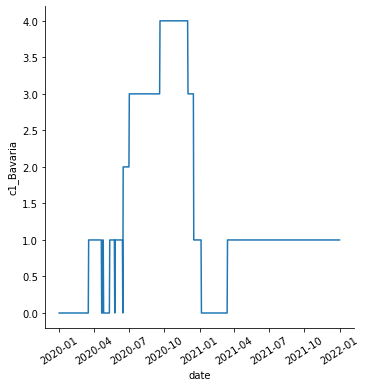

In [36]:
# check for data gaps or inconsistiency via plot
# change inconsistency via manual change function
sns.relplot(data = subind_data_dict['c1']['c1'], x='date' ,y='c1_Bavaria', kind='line' )
plt.xticks(rotation=33)

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01')])

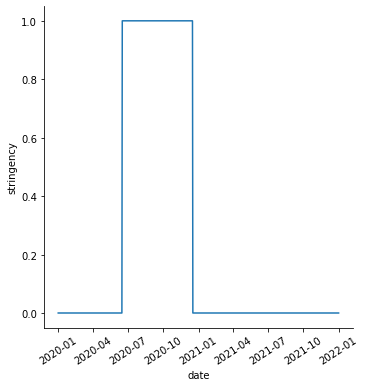

In [37]:
# check for data gaps or inconsistency via plot
# zoomed in on subcat of subindex
sns.relplot(data = subind_data_dict['c1']['Bavaria_Primary Schools (generally for children ages 10 and below)'], x='date' ,y='stringency', kind='line' )
plt.xticks(rotation=33)

---------------------------

# C2 - Restriction and regulation of Businesses with close personal contact (Restaurants, Bars, Personal Grooming Businesses)

In [38]:
subset_subind('c2', 'Restriction and Regulation of Businesses')

,record_id,policy_id,entry_type,update_type,update_level,description,date_announced,date_start,date_end,init_country_level,province,city,type,type_sub_cat,institution_status
1928,R_1lB6xdAmaOZZXVMAm,8894465Am,new_entry,NaN,NaN,"On 12 March 2020, the government of Hamburg (G...",2020-03-12,2020-03-12,2020-04-03,Provincial,Hamburg,NaN,Restriction and Regulation of Businesses,All or unspecified businesses,"This type of business (""All or unspecified bu..."
1929,R_2dACcjGSfrLSGqHBd,2271536Bd,new_entry,NaN,NaN,Berlin (Germany) announces on March 14 the clo...,2020-03-14,2020-03-14,2020-04-19,Provincial,Berlin,NaN,Restriction and Regulation of Businesses,Commercial Businesses,"This type of business (""Commercial Businesses..."
1930,R_DcprShPoAOEX1x7Fh,5251466Fh,new_entry,NaN,NaN,Berlin (Germany) announces on March 14 that re...,2020-03-14,2020-03-14,2020-03-22,Provincial,Berlin,NaN,Restriction and Regulation of Businesses,Restaurants,"This type of business (""Restaurants"") is allo..."
1932,R_3FIf0rkK5YrXqfKBd,7294104Bd,new_entry,NaN,NaN,"On 15 March 2020, the government of Hamburg (G...",2020-03-15,2020-03-15,2020-04-03,Provincial,Hamburg,NaN,Restriction and Regulation of Businesses,Commercial Businesses,"This type of business (""Commercial Businesses..."
1933,R_3FIf0rkK5YrXqfKDn,7294104Dn,new_entry,NaN,NaN,"On 15 March 2020, the government of Hamburg (G...",2020-03-15,2020-03-15,2020-04-03,Provincial,Hamburg,NaN,Restriction and Regulation of Businesses,Other Businesses,"This type of business (""Other Businesses"") is..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3287,R_1241701Oh8rUVp0Fv,9478373Fv,new_entry,NaN,NaN,The state of Hesse in Germany has allowed its ...,2021-10-15,2021-10-15,NaT,Provincial,Hesse,NaN,Restriction and Regulation of Businesses,Retail Businesses,"This type of business (""Retail Businesses"") i..."
3288,R_1241701Oh8rUVp0Gd,9478373Gd,new_entry,NaN,NaN,The state of Hesse in Germany has allowed its ...,2021-10-15,2021-10-15,NaT,Provincial,Hesse,NaN,Restriction and Regulation of Businesses,Supermarkets/grocery stores,"This type of business (""Supermarkets/grocery ..."
3289,R_3PZxbcGGiY6qGWwFv,3132573Fv,update,Change of Policy,Relaxing,Bremen (Germany) closes all non-essential reta...,2020-12-15,2021-12-08,2021-03-28,Provincial,Bremen,NaN,Restriction and Regulation of Businesses,Retail Businesses,"This type of business (""Retail Businesses"") i..."
3290,R_3PZxbcGGiY6qGWwBd,3132573Bd,update,Change of Policy,Relaxing,Bremen (Germany) closes all non-essential reta...,2020-12-15,2021-12-08,2021-03-28,Provincial,Bremen,NaN,Restriction and Regulation of Businesses,Commercial Businesses,"This type of business (""Commercial Businesses..."


In [39]:
institution_status_dummies('c2')

In [40]:
subcat_create_listing('c2')

['Agriculture; forestry and fishing',
 'Transportation (land; water and air)',
 'Paid lodgings (e.g. hotels; motels)',
 'Non-Essential Commercial Businesses',
 'Construction',
 'Warehousing and support activities for transportation',
 'Publishing activities',
 'All or unspecified businesses',
 'Retail Businesses',
 'Private health offices',
 'Financial service activities except insurance and pension funding',
 'Supermarkets/grocery stores',
 'Electricity; gas; steam ;and air conditioning supply',
 'Commercial Businesses',
 'Bars',
 'Pharmacies',
 'Shopping Centers',
 'Information service activities',
 'Other Non-Essential Businesses',
 'Other Businesses',
 'Restaurants',
 'Telecommunications',
 'Personal Grooming Businesses (e.g. hair salons)',
 'Restaurants/Bars']

In [41]:
# extract the subcategories for further usage
list_dict_subcat['c2'] = ['Personal Grooming Businesses (e.g. hair salons)', 'Restaurants', 'Bars']

In [42]:
create_df_subind_subcat_feds('c2', federal_list, list_dict_subcat['c2'])

In [43]:
create_stringency_index_ordinal_provincial('c2', 'new_entry')

create_stringency_index_ordinal_provincial('c2', 'update')

create_stringency_index_ordinal_national('c2', 'new_entry')

create_stringency_index_ordinal_national('c2', 'update')

In [44]:
subind_data_dict['c2']['Berlin_Bars']

,stringency,date,manual_change,manual_id,manual_description,manual_source
0,NaN,2020-01-01,False,,,
1,NaN,2020-01-02,False,,,
2,NaN,2020-01-03,False,,,
3,NaN,2020-01-04,False,,,
4,NaN,2020-01-05,False,,,
...,...,...,...,...,...,...
727,NaN,2021-12-28,False,,,
728,NaN,2021-12-29,False,,,
729,NaN,2021-12-30,False,,,
730,NaN,2021-12-31,False,,,


In [45]:
nan_stringency_filler('c2')

merging_subcat_fed_to_subindex_fed('c2')

In [46]:
subind_data_dict['c2']['Berlin']

,date,Bars,Restaurants,Personal Grooming Businesses (e.g. hair salons),c2
0,2020-01-01,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,0.0,0.0
...,...,...,...,...,...
727,2021-12-28,0.0,0.0,1.0,1.0
728,2021-12-29,0.0,0.0,1.0,1.0
729,2021-12-30,0.0,0.0,1.0,1.0
730,2021-12-31,0.0,0.0,1.0,1.0


In [47]:
merging_subindex_fed_to_subind_df('c2')


In [48]:
subind_data_dict['c2']['c2']

,date,c2_Rheinland-Pfalz,c2_Mecklenburg-Vorpommern,c2_Saxony-Anhalt,c2_Saarland,c2_Bremen,c2_Baden-Wuerttemberg,c2_Saxony,c2_Bavaria,c2_Thuringia,c2_Schleswig-Holstein,c2_Lower Saxony,c2_North Rhine-Westphalia,c2_Hamburg,c2_Brandenburg,c2_Berlin,c2_Hesse,Germany
0,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,2021-12-28,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.5
728,2021-12-29,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.5
729,2021-12-30,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.5
730,2021-12-31,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,3.0,1.5


### Test C2

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01')])

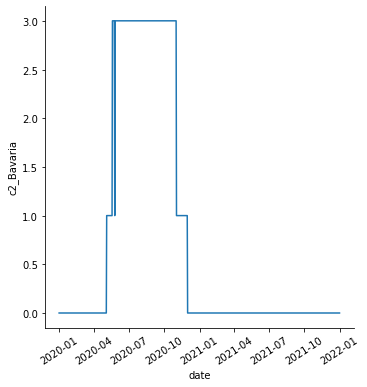

In [49]:
# check for data gaps or inconsistiency via plot
# change inconsistency via manual change function
sns.relplot(data = subind_data_dict['c2']['c2'], x='date' ,y='c2_Bavaria', kind='line' )
plt.xticks(rotation=33)

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01')])

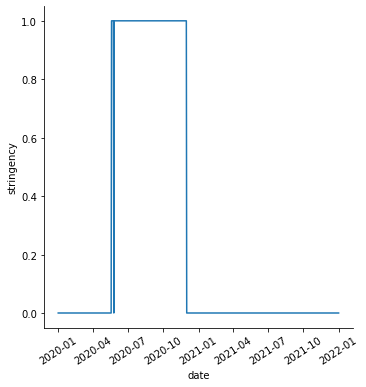

In [50]:
# check for data gaps or inconsistency via plot
# zoomed in on subcat of subindex
sns.relplot(data = subind_data_dict['c2']['Bavaria_Restaurants'], x='date' ,y='stringency', kind='line' )
plt.xticks(rotation=33)

----------------

# C3 - Curfew

In [51]:
subset_subind('c3', 'Curfew')

,record_id,policy_id,entry_type,update_type,update_level,description,date_announced,date_start,date_end,init_country_level,province,city,type,type_sub_cat,institution_status
708,R_2RP5g9bQESSpcauNA,5877228,new_entry,NaN,NaN,"From March 23, 2020 the government of Saxony (...",2020-03-22,2020-03-23,2020-04-19,Provincial,Saxony,NaN,Curfew,NaN,NaN
709,R_YXfOvMdK7m18xS9De,4576552,new_entry,NaN,NaN,Due to the continuing high number of new infec...,2020-10-14,2020-10-14,NaT,Provincial,North Rhine-Westphalia,NaN,Curfew,No the curfew times are always the same regard...,NaN
710,R_2xQTjzQNlDr2Y11De,4576552,update,End of Policy,NaN,Due to the continuing high number of new infec...,2020-10-14,2020-10-14,2020-11-01,Provincial,North Rhine-Westphalia,NaN,Curfew,No the curfew times are always the same regard...,NaN
711,R_1mIpXX8qi1qLTH2De,9831116,new_entry,NaN,NaN,In view of the high number of COVID-19 infecti...,2020-12-11,2020-12-11,2021-01-10,Provincial,Hesse,NaN,Curfew,No the curfew times are always the same regard...,NaN
712,R_2EtO3Tmy3R4DGlYDe,1294161,new_entry,NaN,NaN,In the Free State of Saxony (Germany) issued a...,2020-12-11,2020-12-14,2021-01-10,Provincial,Saxony,NaN,Curfew,No the curfew times are always the same regard...,NaN
713,R_8cEPgVefMfJxEXvDe,888956,new_entry,NaN,NaN,In Saxony (Germany) issued a restriction of mo...,2020-12-11,2020-12-14,2021-01-10,Provincial,Saxony,NaN,Curfew,No the curfew times are always the same regard...,NaN
714,R_DutRR4TioBLNv8ZDe,5716585,new_entry,NaN,NaN,"From 16 December 2020, the Bavarian State Mini...",2020-12-15,2020-12-16,2021-01-10,Provincial,Bavaria,NaN,Curfew,No the curfew times are always the same regard...,NaN
715,R_2tbB0dSiiwqoAyZDe,9188488,new_entry,NaN,NaN,Berlin (Germany) orders a curfew light. One's ...,2020-12-15,2020-12-16,2021-01-31,Provincial,Berlin,NaN,Curfew,No the curfew times are always the same regard...,NaN
716,R_1F3NocoRD7ZmuhpDe,6223031,new_entry,NaN,NaN,"As of December 19, 2020, the Free State of Thu...",2020-12-19,2020-12-19,2021-01-31,Provincial,Thuringia,NaN,Curfew,No the curfew times are always the same regard...,NaN
717,R_1eFaLjvl34EbW9oDe,1294161,update,Change of Policy,Strengthening,In the Free State of Saxony (Germany) issued a...,2020-12-11,2021-01-11,2021-02-07,Provincial,Saxony,NaN,Curfew,No the curfew times are always the same regard...,NaN


In [52]:
# no subcategories for dummy curfew
subcat_create_listing('c3')

['No the curfew times are always the same regardless of the day of the week']

In [53]:
list_dict_subcat['c3'] = ['Curfew']

In [54]:
create_df_subind_subcat_feds('c3', federal_list, list_dict_subcat['c3'])

In [55]:
create_stringency_index_dummy_provincial('c3', 'new_entry')

create_stringency_index_dummy_provincial('c3', 'update')

create_stringency_index_dummy_national('c3', 'new_entry')

create_stringency_index_dummy_national('c3', 'update')

In [56]:
nan_stringency_filler_dummy('c3')

In [57]:
merging_subcat_fed_to_subindex_fed('c3')
subind_data_dict['c3']['Berlin']

,date,Curfew,c3
0,2020-01-01,0.0,0.0
1,2020-01-02,0.0,0.0
2,2020-01-03,0.0,0.0
3,2020-01-04,0.0,0.0
4,2020-01-05,0.0,0.0
...,...,...,...
727,2021-12-28,0.0,0.0
728,2021-12-29,0.0,0.0
729,2021-12-30,0.0,0.0
730,2021-12-31,0.0,0.0


In [58]:
merging_subindex_fed_to_subind_df('c3')
subind_data_dict['c3']['c3']

,date,c3_Rheinland-Pfalz,c3_Mecklenburg-Vorpommern,c3_Saxony-Anhalt,c3_Saarland,c3_Bremen,c3_Baden-Wuerttemberg,c3_Saxony,c3_Bavaria,c3_Thuringia,c3_Schleswig-Holstein,c3_Lower Saxony,c3_North Rhine-Westphalia,c3_Hamburg,c3_Brandenburg,c3_Berlin,c3_Hesse,Germany
0,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
728,2021-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
729,2021-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730,2021-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Test C3

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01')])

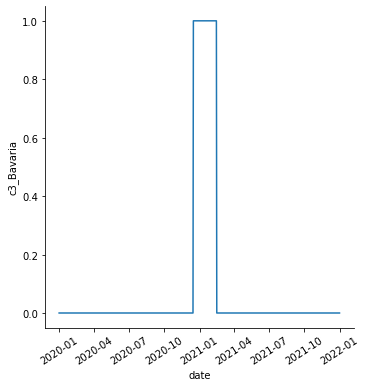

In [59]:
# check for data gaps or inconsistiency via plot
# change inconsistency via manual change function
sns.relplot(data = subind_data_dict['c3']['c3'], x='date' ,y='c3_Bavaria', kind='line' )
plt.xticks(rotation=33)

-----------------------------

# C4 - Internal Border Restrictions

In [60]:
subset_subind('c4', 'Internal Border Restrictions')

,record_id,policy_id,entry_type,update_type,update_level,description,date_announced,date_start,date_end,init_country_level,province,city,type,type_sub_cat,institution_status
1255,R_1GJJuW63QYjVeldNA,7808965,new_entry,NaN,NaN,"As of March 12, Mecklenburg-Vorpommern (German...",2020-03-12,2020-03-12,NaT,Provincial,Mecklenburg-Vorpommern,NaN,Internal Border Restrictions,NaN,NaN
1256,R_3nxypsTiz1VhmHENA,2755211,new_entry,NaN,NaN,"As of March 13, Hamburg (Germany) cancels all ...",2020-03-13,2020-03-13,2020-04-30,Provincial,Hamburg,NaN,Internal Border Restrictions,NaN,NaN
1257,R_3eagyWX4GKmwPPeGl,8454142,new_entry,NaN,NaN,"On 13 March 2020, the government of Hamburg (G...",2020-03-13,2020-03-13,2020-04-30,Provincial,Hamburg,NaN,Internal Border Restrictions,Total border crossing ban,NaN
1258,R_1eseFdxZesieZQ7NA,1934049,new_entry,NaN,NaN,"As of March 16, Lower Saxony (Germany) prohibi...",2020-03-13,2020-03-16,2020-08-26,Provincial,Lower Saxony,NaN,Internal Border Restrictions,NaN,NaN
1259,R_3L4g6LrQ8bdQvtvNA,9197942,new_entry,NaN,NaN,"As of March 16, Lower Saxony (Germany) and the...",2020-03-16,2020-03-16,2020-05-11,Provincial,Lower Saxony,NaN,Internal Border Restrictions,NaN,NaN
1260,R_1H0S0YPiEvbFrFjNA,6999534,new_entry,NaN,NaN,"As of March 17, Hamburg (Germany) prohibits en...",2020-03-16,2020-03-17,2020-04-16,Provincial,Hamburg,NaN,Internal Border Restrictions,NaN,NaN
1261,R_3Eik7g9mgxYAOG1NA,6770813,new_entry,NaN,NaN,"As of March 17, Lower Saxony (Germany) restric...",2020-03-16,2020-03-17,2020-04-18,Provincial,Lower Saxony,NaN,Internal Border Restrictions,NaN,NaN
1262,R_yQS7VdT2qMof0RjNA,6736701,new_entry,NaN,NaN,"On March 17, the government of Mecklenburg-Vor...",2020-03-17,2020-03-17,NaT,Provincial,Mecklenburg-Vorpommern,NaN,Internal Border Restrictions,NaN,NaN
1263,R_rdQKywIUsXtIlxfNA,6736701,update,Change of Policy,Strengthening,"On March 17, the government of Mecklenburg-Vor...",2020-03-17,2020-03-17,NaT,Provincial,Mecklenburg-Vorpommern,NaN,Internal Border Restrictions,NaN,NaN
1264,R_smON1M8gjEUc2atNA,6736701,update,End of Policy,NaN,"On March 17, the government of Mecklenburg-Vor...",2020-03-17,2020-03-17,2020-05-25,Provincial,Mecklenburg-Vorpommern,NaN,Internal Border Restrictions,NaN,NaN


In [61]:
subset_subind('c4', 'Internal Border Restrictions')

# no subcategories for dummy curfew
subcat_create_listing('c4')

list_dict_subcat['c4'] = ['Internal_Border_Restrictions']

create_df_subind_subcat_feds('c4', federal_list, list_dict_subcat['c4'])

create_stringency_index_dummy_provincial('c4', 'new_entry')

create_stringency_index_dummy_provincial('c4', 'update')

create_stringency_index_dummy_national('c4', 'new_entry')

create_stringency_index_dummy_national('c4', 'update')

nan_stringency_filler_dummy('c4')

merging_subcat_fed_to_subindex_fed('c4')

merging_subindex_fed_to_subind_df('c4')
subind_data_dict['c4']['c4']

,date,c4_Rheinland-Pfalz,c4_Mecklenburg-Vorpommern,c4_Saxony-Anhalt,c4_Saarland,c4_Bremen,c4_Baden-Wuerttemberg,c4_Saxony,c4_Bavaria,c4_Thuringia,c4_Schleswig-Holstein,c4_Lower Saxony,c4_North Rhine-Westphalia,c4_Hamburg,c4_Brandenburg,c4_Berlin,c4_Hesse,Germany
0,2020-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2020-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2020-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2020-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2020-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
727,2021-12-28,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
728,2021-12-29,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
729,2021-12-30,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
730,2021-12-31,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Test C4

In [62]:
subind_data_dict['c4']['c4']['c4_Mecklenburg-Vorpommern'].sum()

162.0

(array([18262., 18353., 18444., 18536., 18628., 18718., 18809., 18901.,
        18993.]),
 [Text(18262.0, 0, '2020-01'),
  Text(18353.0, 0, '2020-04'),
  Text(18444.0, 0, '2020-07'),
  Text(18536.0, 0, '2020-10'),
  Text(18628.0, 0, '2021-01'),
  Text(18718.0, 0, '2021-04'),
  Text(18809.0, 0, '2021-07'),
  Text(18901.0, 0, '2021-10'),
  Text(18993.0, 0, '2022-01')])

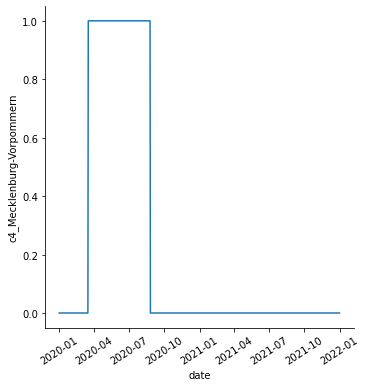

In [63]:
# check for data gaps or inconsistiency via plot
# change inconsistency via manual change function
sns.relplot(data = subind_data_dict['c4']['c4'], x='date' ,y='c4_Mecklenburg-Vorpommern', kind='line' )
plt.xticks(rotation=33)

--------------------

# Interested in the topic?
# I recommend reading my thesis paper available in my GitHub.
# Any questions?
# Contact me on GitHub or LinkedIn.